In [15]:
import helpers.i2c_gui2_helpers as helpers
import datetime
import numpy as np
from tqdm import tqdm

In [34]:
# chip_names = ["ET2p01_Bar4", "ET2p01_Bar12", "ET2p01_PT_NH8", "ET2p01_IME_5"]
# chip_names = ["ET2p03_Bare19", "ET2p03_Bare20", "ET2p03_Bare21", "ET2p03_Bare22"]
# chip_names = ["ET2p01_Bare6"]
chip_names = ["ET2p01_PT_NH21 HV=-50V"]


# 'The port name the USB-ISS module is connected to. Default: /dev/ttyACM0'
port = "/dev/ttyACM0"
# chip_addresses = [0x60, 0x61, 0x62, 0x63]
chip_addresses = [0x60]
ws_addresses = [None] * len(chip_addresses)

In [35]:
i2c_conn = helpers.i2c_connection(port,chip_addresses,ws_addresses,chip_names)

In [36]:
# Calibrate PLL
for chip_address in chip_addresses[:]:
    i2c_conn.calibratePLL(chip_address, chip=None)
# Calibrate FC for all I2C
for chip_address in chip_addresses[:]:
    i2c_conn.asyResetGlobalReadout(chip_address, chip=None)
    i2c_conn.asyAlignFastcommand(chip_address, chip=None)

PLL Calibrated for chip: 0x60
Reset Global Readout done for chip: 0x60
asyAlignFastcommand action done for chip: 0x60


In [37]:
i2c_conn.config_chips(
    do_pixel_check=False,
    do_basic_peripheral_register_check=False, ### Need to re-visit
    do_disable_all_pixels=False,
    do_auto_calibration=False,
    do_disable_and_calibration=True,
    do_prepare_ws_testing=False
)

Peripherals set for chip: 0x60
Disabled pixels (Bypass, TH-3f DAC-3ff) for chip: 0x60
Verifying Broadcast results


Calibrating row: 100%|██████████| 16/16 [00:55<00:00,  3.49s/it]

Auto calibration finished for chip: 0x60


In [38]:
# i2c_conn.get_bl_nw_map()
# bls = i2c_conn.get_bl_nw_map()

### Save BL and NW

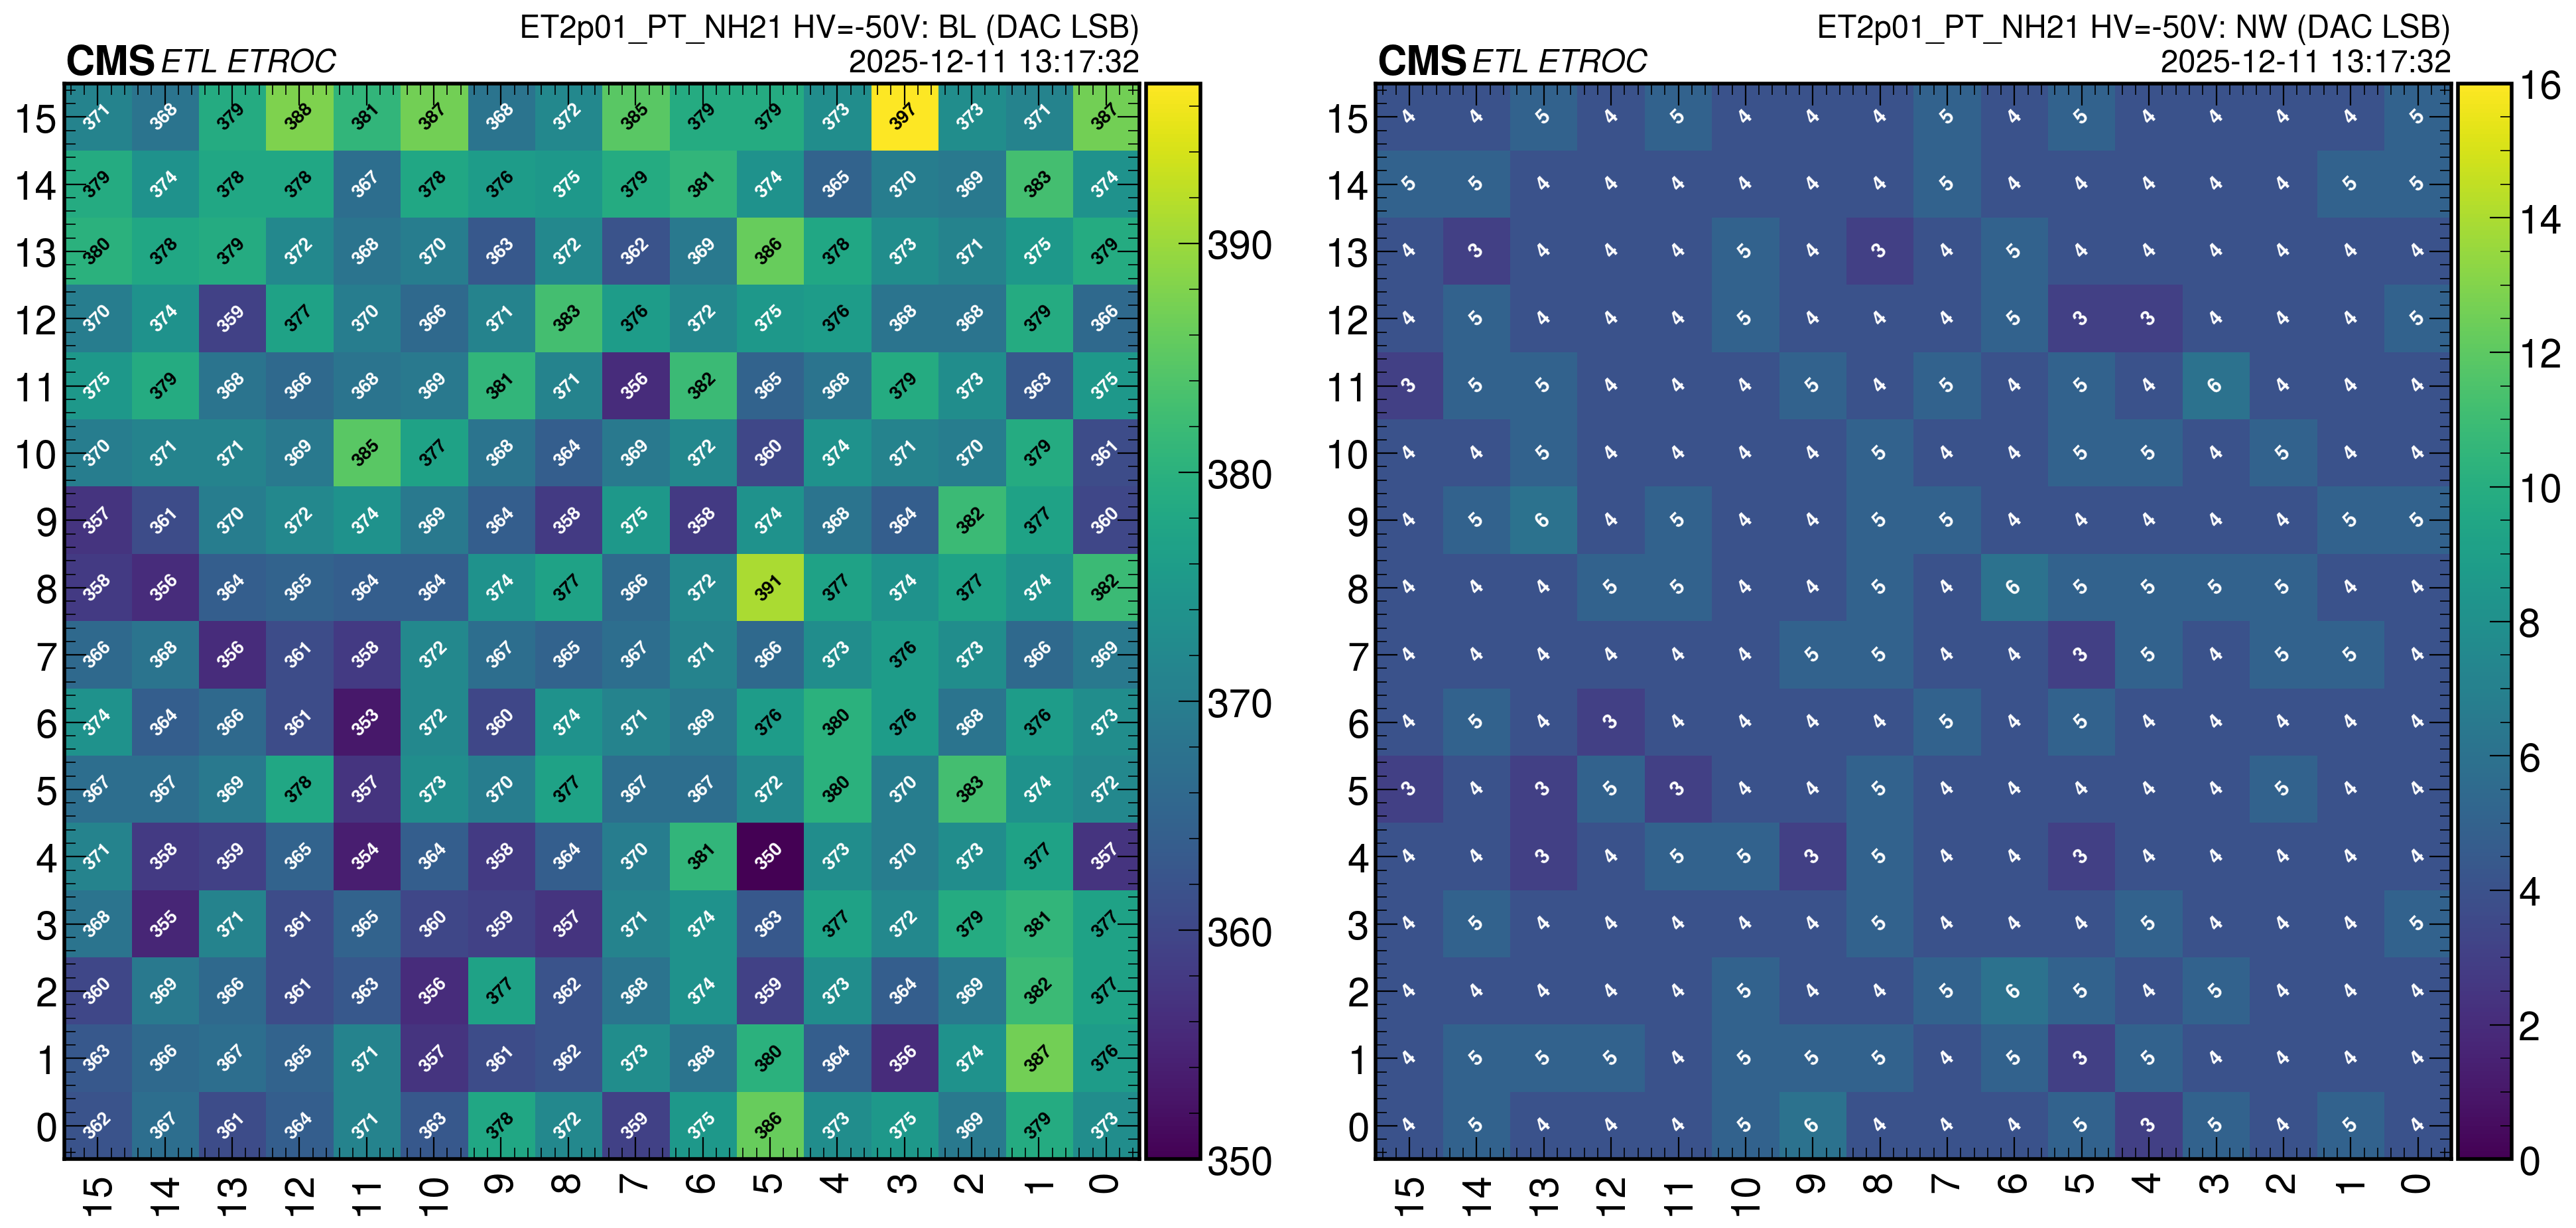

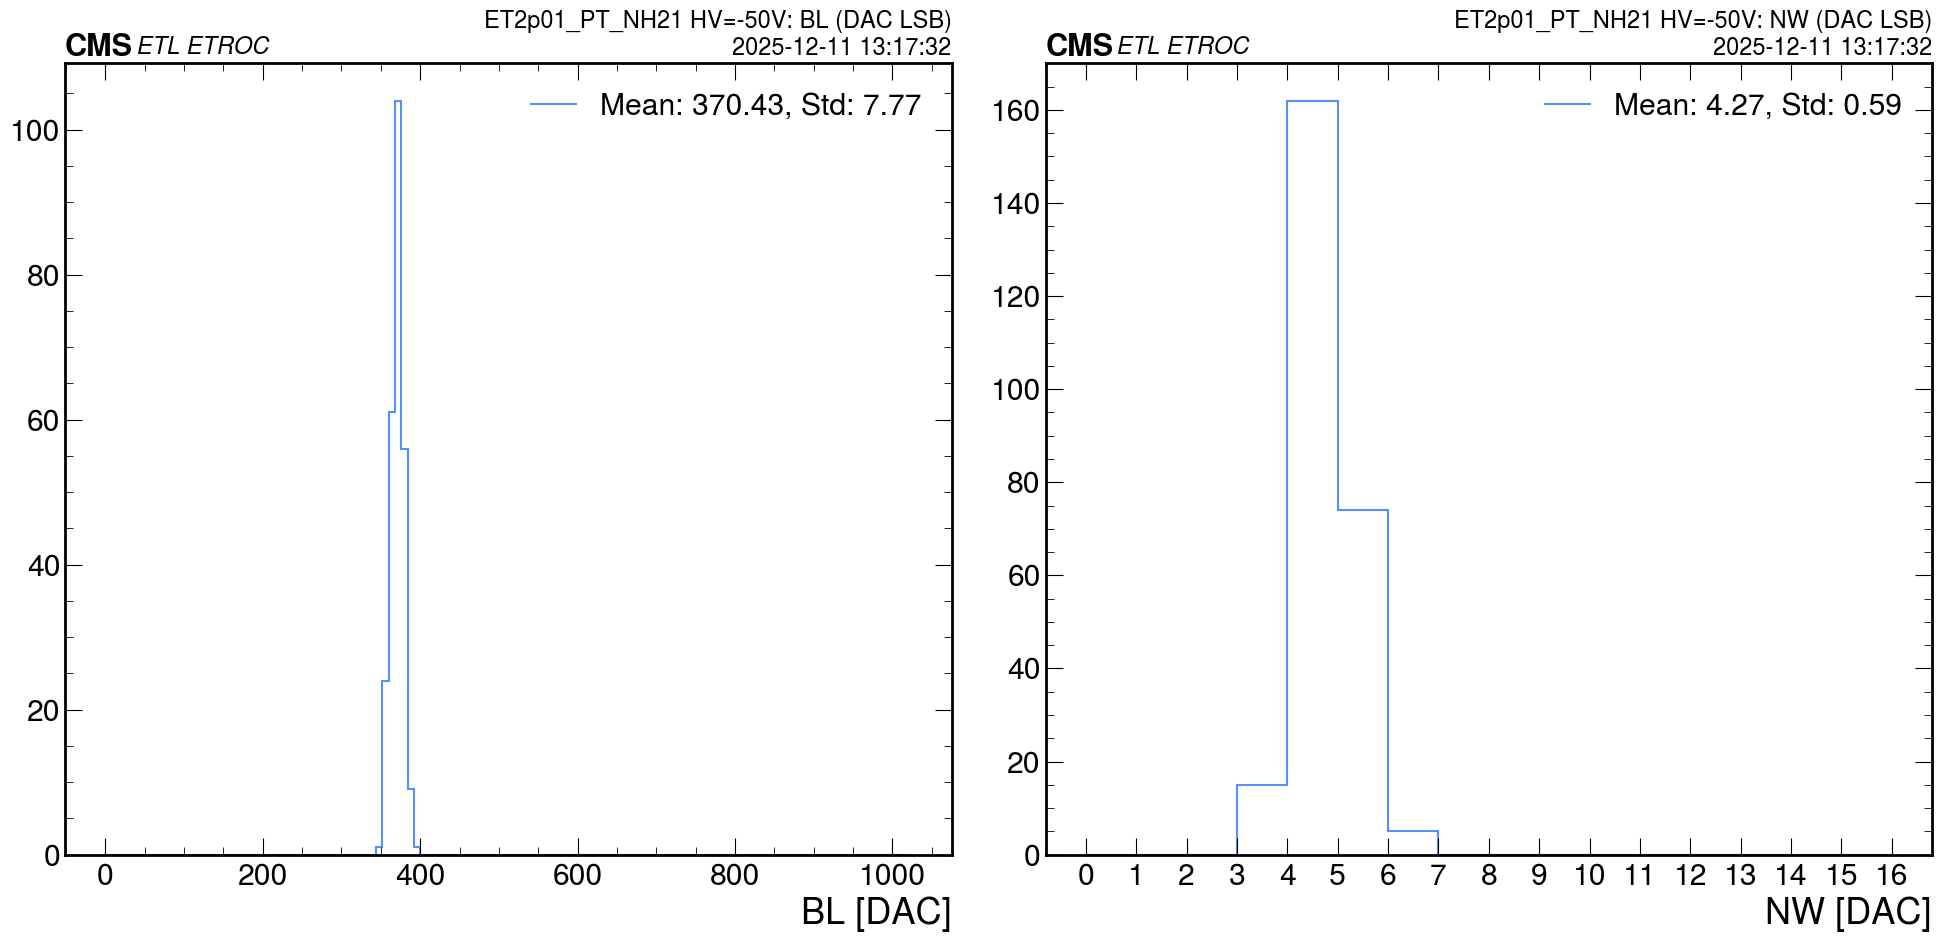

In [39]:
now = datetime.datetime.now().isoformat(sep=' ', timespec='seconds')
i2c_conn.save_baselines(hist_dir='/home/daq/ETROC2/ETROC-History/test_BL_noclock', save_notes=f'{now}')

### Define pixels of interest

In [ ]:
qinj_test = True

if (qinj_test):
    row_list = [12, 12, 13, 13]
    col_list = [6, 9, 6, 9]
    row_list = [12, 12, 13]
    col_list = [6, 9, 6]
    scan_list = list(zip(row_list, col_list))

else:
    col_list, row_list = np.meshgrid(np.arange(16),np.arange(16))
    scan_list = list(zip(row_list.flatten(),col_list.flatten()))

    # row_list = [15] * 8
    # col_list = [13, 12, 11, 10, 9, 8, 7, 6]
    # scan_list = list(zip(row_list, col_list))

print(scan_list)

### Set pixels

In [ ]:
bypass_on = True

if (qinj_test):
    i2c_conn.enable_select_pixels_in_chips(scan_list, Qsel=30, QInjEn=True, Bypass_THCal=bypass_on, power_mode='high', verbose=False)
else:
    i2c_conn.enable_select_pixels_in_chips(scan_list, Qsel=5, QInjEn=False, Bypass_THCal=bypass_on, power_mode='high', verbose=False)

### Set Offset

In [ ]:
offset_broadcast = False
offsets = {
    0x60: 20, # Bar 4
    0x61: 20, # Bar 12
    0x62: 20, # PT-NH8
    0x63: 20, # IME-5
}

if (qinj_test):
    offsets = {
        0x60: 10, # Bar 4
        0x61: 10, # Bar 12
        0x62: 10, # PT-NH8
        0x63: 10, # IME-5
    }

for chip_address in chip_addresses:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)

    if offset_broadcast:
        i2c_conn.set_chip_offsets_broadcast(chip_address, offset=offsets[chip_address], chip=chip)
        del chip
    else:
        i2c_conn.set_chip_offsets(chip_address, pixel_list=scan_list, offset=offsets[chip_address], chip=chip, verbose=False)
        del chip

### Print Invalid FC counter

In [ ]:
for chip_address in chip_addresses:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    chip.read_decoded_value("ETROC2", "Peripheral Status", 'invalidFCCount')
    value_invalidFCCount = chip.get_decoded_value("ETROC2", "Peripheral Status", "invalidFCCount")
    print(f"Chip {hex(chip_address)} Invalid FC Counter: {value_invalidFCCount}")

### Disable only given pixels

In [ ]:
col0 = [(x, 0) for x in range(16)]
row15= [(15, y) for y in range(1, 16)]
ime_nonBB_pixels = col0 + row15

In [ ]:
noisy_pixels = {
    0x60: [
        # (row, col)
        (14, 7),
    ],
    0x63: ime_nonBB_pixels + [(14, 15)],
}

In [ ]:
# Define pixel configuration settings
pixel_config = {
    "disDataReadout": 1,
    "QInjEn": 0,
    "disTrigPath": 1,
    "upperTOATrig": 0x000,
    "lowerTOATrig": 0x000,
    "upperTOTTrig": 0x1ff,
    "lowerTOTTrig": 0x1ff,
    "upperCalTrig": 0x3ff,
    "lowerCalTrig": 0x3ff,
    "upperTOA": 0x000,
    "lowerTOA": 0x000,
    "upperTOT": 0x1ff,
    "lowerTOT": 0x1ff,
    "upperCal": 0x3ff,
    "lowerCal": 0x3ff,
    "enable_TDC": 0,
    "Bypass_THCal": 1,  # Bypass Mode
    "TH_offset": 0x3f,  # Max Offset
    "DAC": 0x3ff,  # Max DAC
}

for chip_address in chip_addresses:
    if chip_address not in noisy_pixels:
        continue

    chip = i2c_conn.get_chip_i2c_connection(chip_address)

    for row, col in noisy_pixels[chip_address]:
        print(f"Disabling of chip {hex(chip_address)} Pixel ({row},{col})")
        chip.row = row
        chip.col = col

        chip.read_all_block("ETROC2", "Pixel Config")

        # Set pixel configuration values on the chip
        for key, value in pixel_config.items():
            chip.set_decoded_value("ETROC2", "Pixel Config", key, value)

        chip.write_all_block("ETROC2", "Pixel Config")

### Disable noisy pixels by removing from the trigger path Only

In [ ]:
for chip_address in chip_addresses:
    if chip_address not in noisy_pixels:
        continue

    chip = i2c_conn.get_chip_i2c_connection(chip_address)

    for row, col in noisy_pixels[chip_address]:
        print(f"Masking from trigger of chip {hex(chip_address)} Pixel ({row},{col})")
        chip.row = row
        chip.col = col

        chip.read_decoded_value("ETROC2", "Pixel Config", 'disTrigPath')
        chip.set_decoded_value("ETROC2", "Pixel Config", 'disTrigPath', 1)
        chip.write_decoded_value("ETROC2", "Pixel Config", "disTrigPath")

### Change FC data/CLK delay on ETROC2 chip

In [ ]:
i2c_conn.config_fc_data_delay(chip_addresses[0], fc_clk_delay=1, fc_data_delay=1)